<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Use Spark and Python to Predict Equipment Purchase</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://github.com/pmservice/wml-sample-models/blob/master/spark/product-line-prediction/images/products_graphics.png?raw=true" alt="Icon"> </th>
   </tr>
</table>

This notebook contains steps and code to get data from the IBM Watson Studio Community, create a predictive model, and start scoring new data. This notebook introduces commands for getting data and for basic data cleaning and exploration, pipeline creation, model training, model persistance to the Watson Machine Learning repository, model deployment, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.5 and Apache Spark 2.1.

You will use a publicly available data set, **GoSales Transactions for Naive Bayes Model**, which details anonymous outdoor equipment purchases. Use the details of this data set to predict clients' interests in terms of product line, such as golf accessories, camping equipment and so on.

**Note**: In this notebook we use GOSales data available on [Watson Studio Community](https://apsportal.ibm.com/exchange-api/v1/entries/8044492073eb964f46597b4be06ff5ea/data?accessKey=9561295fa407698694b1e254d0099600).

## Learning goals

You will learn how to:

-  Load a CSV file into an Apache Spark DataFrame.
-  Explore data.
-  Prepare data for training and evaluation.
-  Create an Apache Spark machine learning pipeline.
-  Train and evaluate a model.
-  Store a pipeline and model in Watson Machine Learning (WML) repository.
-  Deploy a model for online scoring using the Watson Machine Learning (WML) API.
-  Score sample scoring data using the WML API.
-  Explore and visualize the prediction result using the plotly package.


## Contents

This notebook contains the following parts:

1.	[Set up](#setup)
2.	[Load and explore data](#load)
3.	[Create a spark ml model](#model)
4.	[Store the model](#persistence)
5.	[Predict locally and visualize](#visualization)
6.	[Deploy and score in a Cloud](#scoring)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  If you do not have existing instance of [Watson Machine Learning (WML) Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) create one (a free plan is offered and information about how to create the instance is [here](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html))
-  Make sure that you are using a Spark 2.1 kernel
-  Download **GoSales Transactions** from the Watson Studio Community (code provided below).

<a id="load"></a>
## 2. Load and explore data

In this section you will load the data as an Apache Spark DataFrame and perform a basic exploration.

Load the data to the Spark DataFrame by using *wget* to upload the data to gpfs and then use spark *read* method to read data. 

In [ ]:
# Install wget if you don't already have it.
!pip install wget

In [4]:
import wget

link_to_data = 'https://apsportal.ibm.com/exchange-api/v1/entries/8044492073eb964f46597b4be06ff5ea/data?accessKey=9561295fa407698694b1e254d0099600'
filename = wget.download(link_to_data)

print(filename)

GoSales_Tx_NaiveBayes.csv


The csv file GoSales_Tx_NaiveBayes.csv is availble on gpfs now. Load the file to Apache Spark DataFrame using code below.

In [5]:
spark = SparkSession.builder.getOrCreate()

df_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(filename)

In [1]:
from ibmdbpy import IdaDataBase, IdaDataFrame

# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.
idadb = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=dashdb-entry-yp-dal10-01.services.dal.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=dash5014;PWD=85y_E_UgviMC', verbose=True)

df_data = IdaDataFrame(idadb, 'GOSALESDW.SLS_SALES_FACT')
df_data.head()

# You can close the database connection with the following code. Please keep the comment line with the @hidden_cell tag,
# because the close function displays parts of the credentials.
# @hidden_cell
# idadb_22ff48a8fcc54518aa9b4b78f9a913e4.close()
# To learn more about the ibmdby package, please read the documentation: http://pythonhosted.org/ibmdbpy/

> SELECT distinct TABSCHEMA, TABNAME, OWNER, TYPE from SYSCAT.TABLES WHERE (OWNERTYPE = 'U') ORDER BY "TABSCHEMA","TABNAME"
> SELECT COLNAME, TYPENAME FROM SYSCAT.COLUMNS WHERE TABNAME='SLS_SALES_FACT' AND TABSCHEMA='GOSALESDW' ORDER BY COLNO
> SELECT * FROM GOSALESDW.SLS_SALES_FACT ORDER BY "ORDER_DAY_KEY" ASC FETCH FIRST 5 ROWS ONLY


,ORDER_DAY_KEY,ORGANIZATION_KEY,EMPLOYEE_KEY,RETAILER_KEY,RETAILER_SITE_KEY,PRODUCT_KEY,PROMOTION_KEY,ORDER_METHOD_KEY,SALES_ORDER_KEY,SHIP_DAY_KEY,CLOSE_DAY_KEY,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,GROSS_MARGIN,SALE_TOTAL,GROSS_PROFIT
0,20100112,11101,4001,6737,5185,30126,5501,602,194778,20100119,20100119,587,34.90,76.86,71.48,0.5118,41958.76,21472.46
1,20100112,11101,4001,6986,5465,30103,5501,606,194770,20100119,20100119,1776,1.86,6.00,5.70,0.6737,10123.20,6819.84
2,20100112,11101,4001,6986,5465,30100,5501,606,194768,20100119,20100119,129,56.23,96.44,89.69,0.3731,11570.01,4316.34
3,20100112,11101,4001,6737,5185,30132,5501,602,194777,20100119,20100119,576,2.67,10.71,10.28,0.7403,5921.28,4383.36
4,20100112,11101,4001,6737,5185,30128,5501,602,194779,20100119,20100119,214,91.80,180.63,167.99,0.4535,35949.86,16304.66


In [2]:
idadb.ida_query("SELECT COUNT(DISTINCT retailer_site_key), COUNT(retailer_site_key) FROM gosalesdw.sls_rtl_dim")

> SELECT COUNT(DISTINCT retailer_site_key), COUNT(retailer_site_key) FROM gosalesdw.sls_rtl_dim


,1,2
0,847.0,847.0


In [3]:
retailSummary = idadb.ida_query("""
SELECT
    f.retailer_site_key, f.retailer_key,
    gender_code, rtl_city, rtl_prov_state, rtl_country_code, retailer_type_en,
    timestampdiff(64, current timestamp - timestamp(retailer_start_date)) retailer_months, 
    order_method_key, product_key, promotion_key, quantity, sales_total
FROM gosalesdw.sls_sales_fact f    TABLESAMPLE SYSTEM(10.0),
    gosalesdw.sls_rtl_dim d
WHERE
    (f.retailer_site_key, f.retailer_key) = (d.retailer_site_key, d.retailer_key)
""")
print("rows in sample: {0}".format(len(retailSummary)))

> 
SELECT
    f.retailer_site_key, f.retailer_key,
    gender_code, rtl_city, rtl_prov_state, rtl_country_code, retailer_type_en,
    timestampdiff(64, current timestamp - timestamp(retailer_start_date)) retailer_months, 
    order_method_key, product_key, promotion_key, quantity
FROM gosalesdw.sls_sales_fact f    TABLESAMPLE SYSTEM(10.0),
    gosalesdw.sls_rtl_dim d
WHERE
    (f.retailer_site_key, f.retailer_key) = (d.retailer_site_key, d.retailer_key)

rows in sample: 44899


In [7]:
type(retailSummary)

pandas.core.frame.DataFrame

In [12]:
sales_retail_view1 = IdaDataFrame(idadb, 'SLS_RETAILER_VIEW1')

In [13]:
len(sales_retail_view1)

> SELECT CAST(COUNT(*) AS INTEGER) FROM DASH5014.SLS_RETAILER_VIEW1


44702

In [16]:
sales_retail_view1.describe()

> SELECT COLNAME, TYPENAME FROM SYSCAT.COLUMNS WHERE TABNAME='SLS_RETAILER_VIEW1' AND TABSCHEMA='DASH5014' ORDER BY COLNO
> SELECT COUNT("ID"), COUNT("RETAILER_SITE_KEY"), COUNT("RETAILER_KEY"), COUNT("GENDER_CODE"), COUNT("RTL_COUNTRY_CODE"), COUNT("RETAILER_MONTHS"), COUNT("ORDER_METHOD_KEY"), COUNT("PRODUCT_KEY"), COUNT("PROMOTION_KEY"), COUNT("QUANTITY"), COUNT("SALE_TOTAL") FROM DASH5014.SLS_RETAILER_VIEW1
> SELECT AVG(CAST("ID" AS FLOAT)), AVG(CAST("RETAILER_SITE_KEY" AS FLOAT)), AVG(CAST("RETAILER_KEY" AS FLOAT)), AVG(CAST("GENDER_CODE" AS FLOAT)), AVG(CAST("RTL_COUNTRY_CODE" AS FLOAT)), AVG(CAST("RETAILER_MONTHS" AS FLOAT)), AVG(CAST("ORDER_METHOD_KEY" AS FLOAT)), AVG(CAST("PRODUCT_KEY" AS FLOAT)), AVG(CAST("PROMOTION_KEY" AS FLOAT)), AVG(CAST("QUANTITY" AS FLOAT)), AVG(CAST("SALE_TOTAL" AS FLOAT)) FROM DASH5014.SLS_RETAILER_VIEW1
> SELECT COUNT("ID"), COUNT("RETAILER_SITE_KEY"), COUNT("RETAILER_KEY"), COUNT("GENDER_CODE"), COUNT("RTL_COUNTRY_CODE"), COUNT("RETAILER_MONTHS"), C

,ID,RETAILER_SITE_KEY,RETAILER_KEY,GENDER_CODE,RTL_COUNTRY_CODE,RETAILER_MONTHS,ORDER_METHOD_KEY,PRODUCT_KEY,PROMOTION_KEY,QUANTITY,SALE_TOTAL
count,44605.000000,44605.000000,44605.000000,44605.000000,44605.000000,44605.000000,44605.000000,44605.000000,44605.000000,44605.000000,44605.000000
mean,22297.500000,5428.146343,6996.620420,0.435103,4018.026012,110.280755,604.788694,30157.242006,5502.667489,202.703682,10501.331787
std,12879.097236,249.466359,193.145072,0.495867,2223.668737,17.225432,0.855273,77.447067,10.812820,449.358382,18543.949824
min,1.000000,5001.000000,6701.000000,0.000000,1003.000000,58.000000,601.000000,30001.000000,5501.000000,1.000000,0.000000
25%,11176.500000,5227.000000,6832.000000,0.000000,1004.000000,97.000000,605.000000,30099.000000,5501.000000,29.000000,2340.000000
50%,22351.500000,5429.000000,6949.000000,0.000000,4016.000000,113.000000,605.000000,30172.000000,5501.000000,75.000000,5350.400000
75%,33526.500000,5660.000000,7178.000000,1.000000,6002.000000,127.000000,605.000000,30229.000000,5501.000000,204.000000,10295.000000
max,43744.000000,5847.000000,7370.000000,1.000000,7019.000000,136.000000,607.000000,30274.000000,5612.000000,13471.000000,258792.320000


In [17]:
%time
sales_retail_view1.corr()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
> SELECT CORRELATION("ID","RETAILER_SITE_KEY"), CORRELATION("ID","RETAILER_KEY"), CORRELATION("ID","GENDER_CODE"), CORRELATION("ID","RTL_COUNTRY_CODE"), CORRELATION("ID","RETAILER_MONTHS"), CORRELATION("ID","ORDER_METHOD_KEY"), CORRELATION("ID","PRODUCT_KEY"), CORRELATION("ID","PROMOTION_KEY"), CORRELATION("ID","QUANTITY"), CORRELATION("ID","SALE_TOTAL"), CORRELATION("RETAILER_SITE_KEY","RETAILER_KEY"), CORRELATION("RETAILER_SITE_KEY","GENDER_CODE"), CORRELATION("RETAILER_SITE_KEY","RTL_COUNTRY_CODE"), CORRELATION("RETAILER_SITE_KEY","RETAILER_MONTHS"), CORRELATION("RETAILER_SITE_KEY","ORDER_METHOD_KEY"), CORRELATION("RETAILER_SITE_KEY","PRODUCT_KEY"), CORRELATION("RETAILER_SITE_KEY","PROMOTION_KEY"), CORRELATION("RETAILER_SITE_KEY","QUANTITY"), CORRELATION("RETAILER_SITE_KEY","SALE_TOTAL"), CORRELATION("RETAILER_KEY","GENDER_CODE"), CORRELATION("RETAILER_KEY","RTL_COUNTRY_CODE"), CORRELATION("RETAILER_KEY","RETAILER_MONTH

,ID,RETAILER_SITE_KEY,RETAILER_KEY,GENDER_CODE,RTL_COUNTRY_CODE,RETAILER_MONTHS,ORDER_METHOD_KEY,PRODUCT_KEY,PROMOTION_KEY,QUANTITY,SALE_TOTAL
ID,1.000000,-0.017311,-0.018997,-0.014219,0.007604,-0.085353,0.094190,0.026916,0.025821,-0.014138,0.011261
RETAILER_SITE_KEY,-0.017311,1.000000,0.967093,0.122477,0.222771,-0.189674,0.200146,0.029615,-0.040551,0.033425,0.037864
RETAILER_KEY,-0.018997,0.967093,1.000000,0.134179,0.141652,-0.151708,0.184618,0.036843,-0.045849,0.034355,0.037178
GENDER_CODE,-0.014219,0.122477,0.134179,1.000000,-0.019292,0.009890,0.010790,0.005374,-0.011505,0.000743,-0.004434
RTL_COUNTRY_CODE,0.007604,0.222771,0.141652,-0.019292,1.000000,-0.086518,0.043004,-0.037645,0.019062,-0.010941,-0.016381
RETAILER_MONTHS,-0.085353,-0.189674,-0.151708,0.009890,-0.086518,1.000000,-0.048339,0.004840,0.012543,-0.007368,-0.017185
ORDER_METHOD_KEY,0.094190,0.200146,0.184618,0.010790,0.043004,-0.048339,1.000000,0.091099,-0.008856,-0.042024,-0.036593
PRODUCT_KEY,0.026916,0.029615,0.036843,0.005374,-0.037645,0.004840,0.091099,1.000000,-0.181596,-0.322489,-0.403501
PROMOTION_KEY,0.025821,-0.040551,-0.045849,-0.011505,0.019062,0.012543,-0.008856,-0.181596,1.000000,0.112240,0.089368
QUANTITY,-0.014138,0.033425,0.034355,0.000743,-0.010941,-0.007368,-0.042024,-0.322489,0.112240,1.000000,0.215660


In [14]:
from ibmdbpy.learn import KMeans
kmeans = KMeans(3)

In [15]:
kmeans.fit(sales_retail_view1)

> SELECT COUNT(*) FROM SYSCAT.ROUTINES WHERE ROUTINENAME='KMEANS' AND ROUTINEMODULENAME = 'IDAX'
> CALL IDAX.KMEANS ('maxiter=5,model="KMEANS_8983_1528039469",distance="euclidean",idbased=False,randseed=12345,intable=SLS_RETAILER_VIEW1,id="ID",k=3')
<< AUTOCOMMIT >>
<< COMMIT >>
> SELECT * FROM "DASH5014"."KMEANS_8983_1528039469_MODEL"
> SELECT * FROM "DASH5014"."KMEANS_8983_1528039469_COLUMNS"
> SELECT * FROM "DASH5014"."KMEANS_8983_1528039469_COLUMN_STATISTICS"
> SELECT * FROM "DASH5014"."KMEANS_8983_1528039469_CLUSTERS"


In [18]:
kmeans.describe()

KMeans clustering with 3 clusters of sizes 659, 10377, 33495

Cluster means: 
   CLUSTERID  RETAILER_SITE_KEY  RETAILER_KEY  GENDER_CODE  RTL_COUNTRY_CODE  \
0          1        5431.835866   6997.521277     0.471927       4036.182094   
1          2        5426.592405   6994.285095     0.434005       4016.478907   
2          3        5431.016386   6999.719711     0.438855       4039.990749   

   RETAILER_MONTHS  ORDER_METHOD_KEY   PRODUCT_KEY  PROMOTION_KEY    QUANTITY  \
0       110.500759        604.798179  30160.476480    5503.937785  213.464340   
1       110.290581        604.772563  30157.501448    5502.527930  200.103747   
2       110.147056        604.805821  30157.966272    5502.336224  195.634962   

     SALE_TOTAL   RTL_CITY RTL_PROV_STATE RETAILER_TYPE_EN  
0   9577.295266  Singapore          Osaka    Outdoors Shop  
1  10482.223003  Singapore     California    Outdoors Shop  
2  10323.849065   Shanghai          Osaka    Outdoors Shop  

Within cluster sum of squares b

In [43]:
y_kmeans = kmeans.predict(sales_retail_view1)

> CALL IDAX.PREDICT_KMEANS ('intable=SLS_RETAILER_VIEW1,id="ID",outtable="PREDICT_KMEANS_96135_1528044719",model="KMEANS_8983_1528039469"')
<< AUTOCOMMIT >>
<< COMMIT >>
> SELECT distinct TABSCHEMA, TABNAME, OWNER, TYPE from SYSCAT.TABLES WHERE (OWNERTYPE = 'U') ORDER BY "TABSCHEMA","TABNAME"


In [19]:
from ibmdbpy.feature_selection import info_gain

In [23]:
featsel = info_gain(sales_retail_view1)

> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "ID")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RETAILER_SITE_KEY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "ID","RETAILER_SITE_KEY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RETAILER_KEY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "ID","RETAILER_KEY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "GENDER_CODE")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "ID","GENDER_CODE")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_CITY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "ID","RTL_CITY")
> SELECT SUM(-a*LO

> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_PROV_STATE","ORDER_METHOD_KEY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_PROV_STATE","PRODUCT_KEY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_PROV_STATE","PROMOTION_KEY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_PROV_STATE","QUANTITY")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_PROV_STATE","SALE_TOTAL")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_COUNTRY_CODE","RETAILER_TYPE_EN")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_COUNTRY_CODE","RETAILER_MONTHS")
> SELECT SUM(-a*LOG(a)) FROM(SELECT COUNT(*) AS a FROM DASH5014.SLS_RETAILER_VIEW1 GROUP BY "RTL_COUNTRY_CODE","ORDE

In [25]:
featsel

,ID,RETAILER_SITE_KEY,RETAILER_KEY,GENDER_CODE,RTL_CITY,RTL_PROV_STATE,RTL_COUNTRY_CODE,RETAILER_TYPE_EN,RETAILER_MONTHS,ORDER_METHOD_KEY,PRODUCT_KEY,PROMOTION_KEY,QUANTITY,SALE_TOTAL
ID,NaN,9.351573,8.405883,1.046016,7.653087,4.288816,4.128926,2.416106,5.811507,0.572288,7.551724,-0.020839,8.500803,13.461874
RETAILER_SITE_KEY,9.351573,NaN,8.627490,1.259382,7.850661,4.484299,4.364599,2.622393,6.022037,0.380758,2.043349,-0.015542,2.795263,7.398971
RETAILER_KEY,8.405883,8.627490,NaN,0.923462,6.985077,3.990665,4.205907,2.577492,6.006979,0.209797,1.556876,-0.055232,2.237354,6.489051
GENDER_CODE,1.046016,1.259382,0.923462,NaN,0.692344,0.467094,0.305375,0.286965,-0.120146,-0.729601,-0.346275,-0.815227,-0.307463,0.354545
RTL_CITY,7.653087,7.850661,6.985077,0.692344,NaN,3.988634,3.841242,1.253859,4.154361,-0.244381,1.024522,-0.482404,1.640567,5.739941
RTL_PROV_STATE,4.288816,4.484299,3.990665,0.467094,3.988634,NaN,2.019490,0.464540,2.010643,-0.359469,0.273512,-0.554741,0.587670,2.961947
RTL_COUNTRY_CODE,4.128926,4.364599,4.205907,0.305375,3.841242,2.019490,NaN,0.049713,1.831820,-0.422591,-0.084067,-0.575611,0.155574,2.520015
RETAILER_TYPE_EN,2.416106,2.622393,2.577492,0.286965,1.253859,0.464540,0.049713,NaN,0.748450,-0.455048,0.135505,-0.553342,0.225266,1.355310
RETAILER_MONTHS,5.811507,6.022037,6.006979,-0.120146,4.154361,2.010643,1.831820,0.748450,NaN,0.090592,0.423950,-0.010760,0.814968,4.001280
ORDER_METHOD_KEY,0.572288,0.380758,0.209797,-0.729601,-0.244381,-0.359469,-0.422591,-0.455048,0.090592,NaN,-0.191385,-0.368337,-0.153237,0.334551


In [27]:
featsel.columns

Index(['ID', 'RETAILER_SITE_KEY', 'RETAILER_KEY', 'GENDER_CODE', 'RTL_CITY',
       'RTL_PROV_STATE', 'RTL_COUNTRY_CODE', 'RETAILER_TYPE_EN',
       'RETAILER_MONTHS', 'ORDER_METHOD_KEY', 'PRODUCT_KEY', 'PROMOTION_KEY',
       'QUANTITY', 'SALE_TOTAL'],
      dtype='object')

In [31]:
import pandas as pd
feat_importances = pd.Series(featsel, index=featsel.columns)

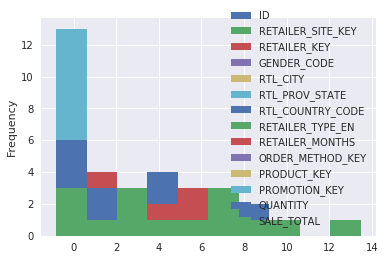

In [42]:
#feat_importances = feat_importances.nlargest(5)
featsel.plot(kind='hist')

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

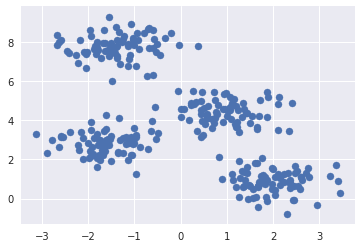

In [35]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [53]:
X[:5].head()

> SELECT * FROM (SELECT "ID","RETAILER_SITE_KEY","RETAILER_KEY","GENDER_CODE","RTL_CITY","RTL_PROV_STATE","RTL_COUNTRY_CODE","RETAILER_TYPE_EN","RETAILER_MONTHS","ORDER_METHOD_KEY","PRODUCT_KEY","PROMOTION_KEY","QUANTITY","SALE_TOTAL" FROM (SELECT TEMP.*, (ROWNUMBER() OVER()-1) AS RN FROM DASH5014.SLS_RETAILER_VIEW1 AS TEMP) WHERE RN  BETWEEN 0 AND 5) ORDER BY "ID" ASC FETCH FIRST 5 ROWS ONLY


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ibmdbpy/indexing.py:118: UserWarning: Row order is not guaranteed if no indexer was given and the dataset was not sorted
  " was given and the dataset was not sorted")


,id,retailer_site_key,retailer_key,gender_code,rtl_city,rtl_prov_state,rtl_country_code,retailer_type_en,retailer_months,order_method_key,product_key,promotion_key,quantity,sale_total
0,1,5464,6985,1,Grenoble,None,6001,Sports Store,122,605,30090,5501,2779,33737.06
1,2,5464,6985,1,Grenoble,None,6001,Sports Store,122,605,30098,5501,73,5933.44
2,3,5283,6858,1,Barcelona,Barcelona,7019,Outdoors Shop,130,602,30033,5501,368,10833.92
3,4,5287,6858,0,Logroño,La Rioja,7019,Outdoors Shop,130,602,30045,5501,105,57354.15
4,5,5287,6858,0,Logroño,La Rioja,7019,Outdoors Shop,130,602,30047,5501,436,26923.00


In [45]:
X = sales_retail_view1
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

KeyError: (slice(None, None, None), 0)

Explore the loaded data by using the following Apache Spark DataFrame methods:
-  print schema
-  print top ten records
-  count all records

In [2]:
df_data.printSchema()

AttributeError: 'IdaDataFrame' object has no attribute 'printSchema'

As you can see, the data contains five fields. PRODUCT_LINE field is the one you would like to predict (label).

In [3]:
df_data.show()

AttributeError: 'IdaDataFrame' object has no attribute 'show'

In [5]:
#print("Number of records: " + str(df_data.count()))
print("Number of records: " + str(len(df_data)))

> SELECT CAST(COUNT(*) AS INTEGER) FROM GOSALESDW.SLS_SALES_FACT
Number of records: 446023


As you can see, the data set contains 60252 records.

<a id="model"></a>
## 3. Create an Apache Spark machine learning model

In this section you will learn how to:

- [3.1 Prepare data](#prep)
- [3.2 Create an Apache Spark machine learning pipeline](#pipe)
- [3.3 Train a model](#train)

### 3.1 Prepare data<a id="prep"></a>

In this subsection you will split your data into: 
- train data set
- test data set
- predict data set

In [6]:
splitted_data = df_data.randomSplit([0.8, 0.18, 0.02], 24)
train_data = splitted_data[0]
test_data = splitted_data[1]
predict_data = splitted_data[2]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
print("Number of prediction records : " + str(predict_data.count()))

AttributeError: 'IdaDataFrame' object has no attribute 'randomSplit'

As you can see your data has been successfully split into three data sets: 

-  The train data set, which is the largest group, is used for training.
-  The test data set will be used for model evaluation and is used to test the assumptions of the model.
-  The predict data set will be used for prediction.

### 3.2 Create the pipeline<a id="pipe"></a>

In this section you will create an Apache Spark machine learning pipeline and then train the model.

In the first step you need to import the Apache Spark machine learning packages that will be needed in the subsequent steps.

In [18]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In the following step, use the StringIndexer transformer to convert all the string fields to numeric ones.

In [19]:
stringIndexer_label = StringIndexer(inputCol="PRODUCT_LINE", outputCol="label").fit(df_data)
stringIndexer_prof = StringIndexer(inputCol="PROFESSION", outputCol="PROFESSION_IX")
stringIndexer_gend = StringIndexer(inputCol="GENDER", outputCol="GENDER_IX")
stringIndexer_mar = StringIndexer(inputCol="MARITAL_STATUS", outputCol="MARITAL_STATUS_IX")

In the following step, create a feature vector by combining all features together.

In [20]:
vectorAssembler_features = VectorAssembler(inputCols=["GENDER_IX", "AGE", "MARITAL_STATUS_IX", "PROFESSION_IX"], outputCol="features")

Next, define estimators you want to use for classification. Random Forest is used in the following example.

In [21]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

Finally, convert the indexed labels back to original labels.

In [22]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=stringIndexer_label.labels)

Now build the pipeline. A pipeline consists of transformers and an estimator.

In [23]:
pipeline_rf = Pipeline(stages=[stringIndexer_label, stringIndexer_prof, stringIndexer_gend, stringIndexer_mar, vectorAssembler_features, rf, labelConverter])

### 3.3 Train the model<a id="train"></a>

Now, you can train your Random Forest model by using the previously defined **pipeline** and **train data**.

In [24]:
train_data.printSchema()

root
 |-- PRODUCT_LINE: string (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MARITAL_STATUS: string (nullable = true)
 |-- PROFESSION: string (nullable = true)



In [25]:
model_rf = pipeline_rf.fit(train_data)

You can check your **model accuracy** now. Use **test data** to evaluate the model.

In [26]:
predictions = model_rf.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.585359
Test Error = 0.414641


You can tune your model now to achieve better accuracy. For simplicity, the tuning example is omitted in this example.

<a id="persistence"></a>
## 4. Store the model in the WML repository

In this section you will learn how to use Python client libraries to store your pipeline and model in WML repository.

- [4.1 Import the libraries](#lib)
- [4.2 Save pipeline and model](#save)
- [4.3 Load the model](#load)

### 4.1 Import the libraries<a id="lib"></a>

First, you must install and import the `watson-machine-learning-client` libraries.

**Note**: Python 3.5 and Apache Spark 2.1 is required.

In [27]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [28]:
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s86b-18e61b28c674e4-3fbaf243aed6/.local/lib/python3.5/site-packages
Requirement already up-to-date: tqdm in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s86b-18e61b28c674e4-3fbaf243aed6/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tabulate in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s86b-18e61b28c674e4-3fbaf243aed6/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: urllib3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s86b-18e61b28c674e4-3fbaf243aed6/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: certifi in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s86b-18e61b28c674e4-3fbaf243aed6/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: pandas in 

In [31]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Authenticate to the Watson Machine Learning service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the [Service Credentials](https://console.bluemix.net/docs/services/service_credentials.html#service_credentials) tab of the service instance that you created on IBM Cloud. 

If you cannot see the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.

In [29]:
wml_credentials={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

In [30]:
# The code was removed by DSX for sharing.

In [32]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 4.2 Save the pipeline and model<a id="save"></a>

In this subsection you will learn how to save pipeline and model artifacts to your Watson Machine Learning instance.

In [35]:
published_model_details = client.repository.store_model(model=model_rf, meta_props={'name':'Product line model'}, training_data=train_data, pipeline=pipeline_rf)

In [36]:
model_uid = client.repository.get_model_uid(published_model_details)
print(model_uid)

70a8b8ad-ef04-4d9f-a1e7-679719577b62


Get saved model metadata from Watson Machine Learning.

**Tip**: Use `client.repository.ModelMetaNames.show()` to get the list of available props.

In [37]:
client.repository.ModelMetaNames.show()

-----------------------  ----  --------
META_PROP NAME           TYPE  REQUIRED
NAME                     str   Y
DESCRIPTION              str   N
AUTHOR_NAME              str   N
AUTHOR_EMAIL             str   N
FRAMEWORK_NAME           str   N
FRAMEWORK_VERSION        str   N
FRAMEWORK_LIBRARIES      list  N
RUNTIME_NAME             str   N
RUNTIME_VERSION          str   N
TRAINING_DATA_REFERENCE  dict  N
EVALUATION_METHOD        str   N
EVALUATION_METRICS       list  N
-----------------------  ----  --------


### 4.3 Load the model<a id="load"></a>

In this subsection you will learn how to load a saved model from a specified instance of Watson Machine Learning.

In [38]:
loaded_model = client.repository.load(model_uid)

You can print the model name to make sure that model has been loaded correctly.

In [39]:
print(type(loaded_model))

<class 'pyspark.ml.pipeline.PipelineModel'>


As you can see the name is correct. 

<a id="visualization"></a>
## 5. Predict locally and visualize

In this section you will learn how to score test data using the loaded model and visualize the prediction results with the plotly package.

- [5.1 Make a local prediction using previously loaded model and test data](#local)
- [5.2 Use Plotly to visualize data](#plotly)

### 5.1 Make a local prediction using previously loaded model and test data<a id="local"></a>

In this subsection you will score the *predict_data* data set.

In [40]:
predictions = loaded_model.transform(predict_data)

Preview the results by calling the *show()* method on the predictions DataFrame.

In [41]:
predictions.show(5)

+-----------------+------+---+--------------+----------+-----+-------------+---------+-----------------+------------------+--------------------+--------------------+----------+--------------------+
|     PRODUCT_LINE|GENDER|AGE|MARITAL_STATUS|PROFESSION|label|PROFESSION_IX|GENDER_IX|MARITAL_STATUS_IX|          features|       rawPrediction|         probability|prediction|      predictedLabel|
+-----------------+------+---+--------------+----------+-----+-------------+---------+-----------------+------------------+--------------------+--------------------+----------+--------------------+
|Camping Equipment|     F| 20|        Single|     Other|  0.0|          0.0|      1.0|              1.0|[1.0,20.0,1.0,0.0]|[5.40697857263576...|[0.27034892863178...|       1.0|Personal Accessories|
|Camping Equipment|     F| 20|        Single|     Other|  0.0|          0.0|      1.0|              1.0|[1.0,20.0,1.0,0.0]|[5.40697857263576...|[0.27034892863178...|       1.0|Personal Accessories|
|Camping E

By tabulating a count, you can see which product line is the most popular.

In [42]:
predictions.select("predictedLabel").groupBy("predictedLabel").count().show(truncate=False)

+------------------------+-----+
|predictedLabel          |count|
+------------------------+-----+
|Camping Equipment       |752  |
|Golf Equipment          |67   |
|Mountaineering Equipment|42   |
|Personal Accessories    |355  |
+------------------------+-----+



### 5.2 Use Plotly to visualize data <a id="plotly"></a>

In this subsection you will use the Plotly package to explore the prediction results. Plotly is an online analytics and data visualization tool.

First, you need to install the required packages. You can do it by running the following code. Run it only one time.

In [ ]:
!pip install plotly
!pip install cufflinks==0.8.2

Import Plotly and the other required packages.

In [43]:
import sys
import pandas
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objs as go

init_notebook_mode(connected=True)
sys.path.append("".join([os.environ["HOME"]])) 

Convert the Apache Spark DataFrame to a Pandas DataFrame.

In [44]:
predictions_pdf = predictions.select("prediction", "predictedLabel", "GENDER", "AGE", "PROFESSION", "MARITAL_STATUS").toPandas()

Plot a pie chart that shows the predicted product-line interest.

In [45]:
cumulative_stats = predictions_pdf.groupby(['predictedLabel']).count()
product_data = [go.Pie(labels=cumulative_stats.index, values=cumulative_stats['GENDER'])]
product_layout = go.Layout(title='Predicted product line client interest distribution')

fig = go.Figure(data=product_data, layout=product_layout)
iplot(fig)

With this data set, you might want to do some analysis of the mean AGE per product line by using a bar chart.

In [46]:
age_data = [go.Bar(y=predictions_pdf.groupby(['predictedLabel']).mean()["AGE"], x=cumulative_stats.index)]

age_layout = go.Layout(
    title='Mean AGE per predicted product line',
    xaxis=dict(title = "Product Line", showline=False),
    yaxis=dict(title = "Mean AGE"))

fig = go.Figure(data=age_data, layout=age_layout)
iplot(fig)

Based on the bar plot you created, you might make the following conclusion: The mean age for clients that are interested in golf equipment is predicted to be over 50 years old.

<a id="scoring"></a>
## 6. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record using the `watson-machine-learning-client`.

**Note:** You can also use the REST API to deploy and score.
For more information about REST APIs, see the [Swagger Documentation](http://watson-ml-api.mybluemix.net/).

#### Create online deployment for published model.

In [48]:
deployment_details = client.deployments.create(model_uid=model_uid, name='Product line model deployment')



#######################################################################################

Synchronous deployment creation for uid: '3112f5b0-4c72-4e78-ac33-325b2dc38bbe' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='3112f5b0-4c72-4e78-ac33-325b2dc38bbe'
------------------------------------------------------------------------------------------------




#### Create an online scoring endpoint. 

In [49]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/3f6e5c2b-4880-46aa-9d79-62e90ccc9d56/published_models/70a8b8ad-ef04-4d9f-a1e7-679719577b62/deployments/3112f5b0-4c72-4e78-ac33-325b2dc38bbe/online


Now, you can send new scoring records (new data) for which you would like to get predictions. To do that, run the following sample code: 

In [50]:
payload_scoring = {"fields": ["GENDER","AGE","MARITAL_STATUS","PROFESSION"],"values": [["M",23,"Single","Student"],["M",55,"Single","Executive"]]}

client.deployments.score(scoring_url, payload_scoring)

{'fields': ['GENDER',
  'AGE',
  'MARITAL_STATUS',
  'PROFESSION',
  'PRODUCT_LINE',
  'label',
  'PROFESSION_IX',
  'GENDER_IX',
  'MARITAL_STATUS_IX',
  'features',
  'rawPrediction',
  'probability',
  'prediction',
  'predictedLabel'],
 'values': [['M',
   23,
   'Single',
   'Student',
   'Camping Equipment',
   0.0,
   6.0,
   0.0,
   1.0,
   [0.0, 23.0, 1.0, 6.0],
   [5.258712981131878,
    6.723421733525897,
    6.0132018750333724,
    0.218060296213069,
    1.7866031140957863],
   [0.26293564905659383,
    0.3361710866762948,
    0.3006600937516686,
    0.010903014810653448,
    0.0893301557047893],
   1.0,
   'Personal Accessories'],
  ['M',
   55,
   'Single',
   'Executive',
   'Camping Equipment',
   0.0,
   3.0,
   0.0,
   1.0,
   [0.0, 55.0, 1.0, 3.0],
   [3.6000096318286547,
    4.060237825988732,
    3.8628119611335734,
    8.339956386992652,
    0.13698419405638748],
   [0.18000048159143273,
    0.20301189129943661,
    0.19314059805667866,
    0.4169978193496326,
   

As you can see we predict that a 23-year-old male student is interested in personal accessories (predictedLabel: Personal Accessories, prediction: 1.0). You can also see that single, 55 years old man is interested in golf equipment.

<a id="summary"></a>
## 7. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use Apache Spark machine learning as well as Watson Machine Learning for model creation and deployment. 
 
Check out our [Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>